# Chapter 17 - Model Selection, Machine Learning as Optimization, Hyperparameter Tuning, Cross Validation

In machine learning, making fewer assummptions and restrictions means that we have many options for choosing and adapting models. One important part of machine learning is therefore to select the models and how to tune them so that we get good generalization.  

Model selection is about finding a model that will give good predictions for new data from the same underlying distribution. It can also be about reflecting the process that we are modelling, but that is usually less of a focus in machine learning. The underlying distribution is usually unknown, and without making assumptions we can only use the empirical approach introduced in the previous chapter. 

There are several ways to select among the vast number of choices for models and for evaluating their performance. Machine learning is often formulated as some form of optimization, i.e. minimising an error metric or maximizing likelyhood. The optimization process can be a closed form clacuation (linear regression), an iterative algorithm (logistic regression), or be a search process (decision tree splits). 

It is important, however, that the quantity we are ultimately interested in - the prediction quality on unseen data - is by definition not directly available to an optimisation procedure. We therefore need to set up specific approaches to the model optimisation and selection processes to make sure we optimise for the right target. 

## Model Selection

In machine learning we fit models to training data, but since the goal is to have good predictions for new input data, the performance on the training data is not a good indicator of model quality. Therefore we held out part of the available data as a test dataset. To give us an unbaised estimate of the model's generalization performance, we need to use unseen test data, for which the model was not optimized. If we select a model based on a data set, that dataset is not longer suitable as a test set. Therefore we need a separate validation set, that we use for model selection, in addition to the test set, that we use for estimating generalization performance. 

There are sometime cases, we have an effectively infinite supply of labelled data (e.g. text on the internet). However, in most cases, labelled data is not easy to obtain and we need to make the most of the data we have. 

### Data preprocessing - Dividing and Scaling

We are now going the use the iris dataset again, as in the previous chapter. We will, however, do two things differently: 1) we will **scale** the feature values and 2) we will divide the data into 2 subsets, the **training, validation and testing set**.

**Scaling:** since we don't make assumptions about the data, it could be that the data values are not suitable  for the machine learning algorithms we apply. E.g. this might cause an error or the optimizer might not converge, so that we don't get a meaningful result. 
There are different scaling requirements for different models. E.g. decision trees and knn classifiers usually need to scaling. Many other models, like logistic regression or neural networks, as sensitive to scaling.   Standardization, like in chapter 8, to a mean of 0 and a standard deviation of 1 works well for many machine learning. An alternative approach is normalization, which ensures that all values are between 0 and 1. 

In the code below, we first split the training set from the rest and split the rest into test and validation set. Then we use the Scikit-Learn StandardScaler to standardize the dataset. 

In [49]:
from sklearn.datasets import load_iris
iris = load_iris()

seed = 1 # this is used with the train_test_split to avoid random behaviour for this demo
X = iris.data
y = iris.target

from sklearn.model_selection import train_test_split
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=.4,random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=.5,random_state=seed)
print(len(y_train),len(y_val),len(y_test))

# most classifiers work better with scaled input data
from sklearn.preprocessing import StandardScaler
sclr = StandardScaler()
sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

X_train_scl = sclr.fit_transform(X_train) # scale all 3 sets:
X_val_scl = sclr.fit_transform(X_val)
X_test_scl = sclr.fit_transform(X_test)

90 30 30


### Another Classifier - Nearest Neighbor

We now use another classifier: the K-Nearest--Neighbor (KNN) classifier. This classifier is very simple: is views the feature values of an item as a vectors. For a new feature vector, we calculate the $k$ closest feature vectors in our training set. We then look up the classes belonging to these $k$ feature vectors and choose the most frequent one as our KNN prediction. The number $k$ determines the behaviour. In the simplest case we can choose $1$, which makes it easy to select the predicted class (no ties).  

This is a very simple classifier, but it can be quite effective. In order to select whether to use KNN or Decision Trees, we train both types of model on our training set and calculate the performance on the validation set. We also calculate the performance on the test set, which is a more realistic estimate of the performance on unseen data. 

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# train both classifiers
dtc = DecisionTreeClassifier(max_depth=2,random_state=0)
dtc.fit(X_train_scl,y_train)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scl,y_train)

# helper functions to calculate the accuracy values on train, validation and test set. 
def accuracy(X,y,predictor):
    return np.sum(np.equal(predictor.predict(X),y))/len(X)

def trainValTestAcc(predictor):
    vals = {}
    vals['train'] = accuracy(X_train_scl,y_train,predictor)
    vals['val'] = accuracy(X_val_scl,y_val,predictor)
    vals['test'] = accuracy(X_test_scl,y_test,predictor)
    return vals

print(" DT: ",trainValTestAcc(dtc))
print("KNN: ",trainValTestAcc(knn))

 DT:  {'train': 0.9555555555555556, 'val': 0.9666666666666667, 'test': 1.0}
KNN:  {'train': 1.0, 'val': 0.8666666666666667, 'test': 0.9666666666666667}


We see similar performance for both models. However, the validation and test set results don't seem to agree on which model is better. The typical reason for a situation like this is that the dataset is too small, so that we see variation caused by the selection of the datasets rather than. In order to test whether data selection is the cause of the difference, we can look at different ways to split the data by changing the value of the `seed` variable above. That has the effecto of changing re results of train_test split. You can try it our for yourself with the notebooks provided with this book, but here are some results to study.

`
seed = 1
 DT:  {'train': 0.9555555555555556, 'val': 0.9666666666666667, 'test': 1.0}
KNN:  {'train': 1.0, 'val': 0.8666666666666667, 'test': 0.9666666666666667}
seed = 2
 DT:  {'train': 0.9777777777777777, 'val': 0.9333333333333333, 'test': 0.9}
KNN:  {'train': 1.0, 'val': 0.9333333333333333, 'test': 0.9}
seed = 3
 DT:  {'train': 0.9666666666666667, 'val': 0.8333333333333334, 'test': 0.9666666666666667}
KNN:  {'train': 1.0, 'val': 0.9, 'test': 0.9333333333333333}
seed = 4
 DT:  {'train': 0.9555555555555556, 'val': 0.7333333333333333, 'test': 0.9333333333333333}
KNN:  {'train': 1.0, 'val': 0.8, 'test': 0.9333333333333333}
seed = 5
 DT:  {'train': 0.9666666666666667, 'val': 0.9333333333333333, 'test': 0.9}
KNN:  {'train': 1.0, 'val': 1.0, 'test': 0.9333333333333333}
seed = 6 
 DT:  {'train': 0.9666666666666667, 'val': 0.9, 'test': 0.9666666666666667}
KNN:  {'train': 1.0, 'val': 0.9, 'test': 0.9666666666666667}
`

We can see that the results on the validation and test results vary more between between different data splits than between the classification models. In order to get a clearer picture, it would be best to get more data. Based on the law of large numbers (see chapter 5), the distribution of the dataset will be closer to the true distribution if the dataset is larger.  

However, getting more data is often not feasible. A method to make most use of small datasets is called **Cross Validation**. The idea of cross validation is to divide the data systematically such that each data item is used as validation data once. 

### Cross-Validation

In **k-Fold Cross-Validation**, we divide the whole dataset into $k$ subsets (folds) of approximately equal size. Each fold is used once used as the test set, while the remaining $k-1$ are used as the training set. In this way we get $k$ different samples of the performance. In the extreme case of $k = n$, where $n$ is the size of the dataset, it is called *leave-one-out cross-validation*.

There are ready-made implementations of k-fold cross available. In Scikit-Learn, the KFold class works similar to `train_test_split`, but it generates $k$ splits. 

In [112]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=15,shuffle=True,random_state=0)
knn_test_acc = []
for train,test in kf.split(X,y):
    knn.fit(X[train],y[train])
    knn_test_acc.append(np.sum(np.equal(knn.predict(X[test]),y[test]))/len(y[test]))
print(knn_test_acc)
print(np.mean(knn_test_acc))

dtc_test_acc = []
for train,test in kf.split(X,y):
    dtc.fit(X[train],y[train])
    dtc_test_acc.append(np.sum(np.equal(dtc.predict(X[test]),y[test]))/len(y[test]))
print(dtc_test_acc)
print(np.mean(dtc_test_acc))

[1.0, 1.0, 1.0, 0.9, 0.9, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9]
0.9600000000000001
[1.0, 0.9, 1.0, 0.8, 0.9, 0.8, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 0.8, 0.9]
0.9333333333333335


As we can see, the training set predictions are all correct, as was already clear from the diagram. 



In [113]:
from scipy.stats import wilcoxon 
wilcoxon(dtc_test_acc,knn_test_acc, zero_method='wilcox', correction=False, alternative='two-sided')

/Users/tweyde/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/tweyde/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.04550026389635839)

### Generalization, overfitting and regularization

As long the class labels are the same for the equal input values, it is possible to break down each node to that the leaf contains only one class, as can be seen in the example above. The actual goal of machine learning is however, to make good predictions on new data, assuming is is of the same nature as the training data. Or probabilistically speaking: that it was drawn from the same distribution. To measure this capability in practice, we use an empirical approach with a separate dataset for testing. 

We created a separate test set earlier, which contains data from the same source as our training set, but that was not used in training. 
We can now calculate the accuracy of our trained model on that test set. 
We use below the vectorised form, which is simpler but it equvalent to the code in above.

In [26]:
import numpy as np
np.sum(np.equal(clf_full.predict(X_test),y_test))/len(X_test)

0.88

As we can see, the model gets only 88% of the test set right. This performance on unsee data (i.e. data not used in training the mode) is called **generalization**. The generalization performance in typically lower than the training set performance. This can be attributed to missing information in the input, i.e. missing features that would help the prediction and to truely random components in the target data. 

A model that fits perfectly to a training dataset data is often not ideal as it learns the specifics of the training set which do not necessarily apply to other data as in our test set. For example, in the tree shown above, we have one example of a 'versicolor' iris with a long and wide petal but a short and wide sepal in the lower right corner. This is not typical, however, as most 'versicolor' samples have short wide petals and long sepals. The special rule for one example is unlikely to  help for new samples. This effect is called **overfitting** a model.

**Regularisation** is a general term for techniques that prevent models from overfitting by limiting their ability to adapt. With a decision tree, a simple form of regularisation is to make the tree smaller. 
    

### Example 2: Improving Generalization by Regularizing the Model

Below we allow only two levels in the tree, when we fit it to the training set. We see that 2 of the 3 leaves contain samples of multiple classes, so the model fits slightly worse to the training data and training accuracy will be lower. 

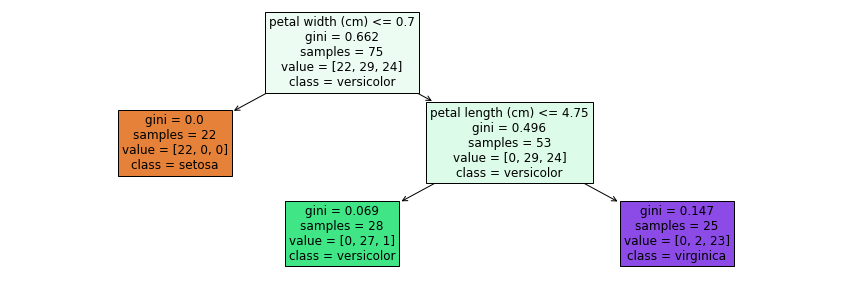

In [13]:
clf_small = tree.DecisionTreeClassifier(max_depth=2,random_state=0)
clf_small.fit(X_train,y_train)
plt.figure(figsize=(15,5))
tree.plot_tree(clf_small,fontsize=12,feature_names=iris.feature_names,class_names=iris.target_names,filled=True)
pass

When we calculate the test and training set accuracy for this simpler model on our test set, we see that the values are much closer and particularly the test result on the training set is better. This indicates that we have reduced overfitting and created a model that generalizes better.

In [27]:
# Training set accuracy
train_acc = 1-np.sum(np.abs(clf_small.predict(X_train)-y_train))/len(X_train)
# Test set accuracy 
test_acc = 1-np.sum(np.abs(clf_small.predict(X_test)-y_test))/len(X_test)
print("Training accuracy: ", train_acc, ", Test accuracy: ",test_acc)

Training accuracy:  0.96 , Test accuracy:  0.9466666666666667


### Summary

Machine Learning approaches the problems of learning form data in a direct way, often relaxing the traetment of probabilities and distributions. 
The general setting is to learn a model that estimates, in ML terminology: predicts, an unknown dependent value, in ML terminology: the label. 

The most common form of machine learning is supervised learning, where we have labelled data that we use to fit (train) the model. 
In order to evaluate the quality of our model, we need to use a 

### TextBox: Decision Tree Learning

In this example, we build the decision tree with an algorithm implemented in the class DecisionTreeClassifier when using the method `fit`. There are many variants of algorithms for decision tree building. The simplest one, which we use here, has a few simple steps and uses only a few concepts. 

Dataset partitioning - splitting the set of data items into two sets, based on an attribute value.
Impurity Metric - a metric for the lack of classification quality for a given set
Splitting criterion - a rule when to stop growing the tree

The simplest version of the process is this (in pseudocode):

- Select a impurity metric and a splitting criterion 
- Start with the whole dataset assigned to the root node of the tree and call the method **split** on it

**`split(node)`**`
    Select an attribute of the samples at random.
    Split the samples in the current node into two subsets, `*`left`*` and `*`right`*`, 
    depending on whether the sample's attribute value is below some threshold or not.
    Determine the threshold value for that attribute that maximises your metric 
    If your can improve over previous metrics: 
        Create two new child nodes, `**`left`**` and `**`right`**`, and assign the `*`left`*` and `*`right`*` subsets to them.
        Call `**`split(left)`**` and `**`split(right)`**  
    
- Split calls itsef recursively as it generates more cild nodes. 
- Once all calls are executed, we have a tree, where each node is associated wits a) an attribute and threshold, b) a subset of the data, c) its impurity value, and d) its most frequent class.  
- For a new data item, we apply the attribute and threshold to traverse through the tree from the root (depitcted on top) to a leaf of th tree and assign the most frequent class of that leaf to the item. 

**In our examples** every node has also the distribution of classes in its subset shown as `value`. We can use that as an estimate of class probabilities, but for a small tree like in our examples, that would be unreliable.  

The metric used in our examples is the **Gini Impurity** $I_G$. It measures the probability of a random element labelled with a random class, to have the wrong label. It is calculated $i$ in a set: ${I}_{G}(p)=\sum _{i=1}^{J}p_{i}(1-p_{i}) = 1-\sum _{i=1}^{J}p_{i}^{2}$, where $p_i$ which is the proportion of samples of a class in the set. To aggregate over two nodes after splitting, we take the average weighted by the number of items in each set.

The corresponding splitting criterion for the Gini Impurity is the **Gini Gain** $G_G$. It is defined as the differenece between **Gini Impurity** of the original set $all$ and the weighted average of the impurities of the $left$ and $right$ sets. It is calculates like this: 
$$G_G = \frac{I_G(left)\times|left| + I_G(left)\times|right|}{|all|} - I_G(all)$$
where $|s|$ is the cardinality (number of items) in set $s$. The higher the gain, the 






Exercises

1) Implement your own version of generat `train_test_split`, so that it generates three sets (train, validation, test). You should accept two arguments, `train_size` and `validation_size`. You then need to internally determine the `test_size`. 
2) What is a necessary condition for the arguments to be valid? Implement a test and print an error message if the arguments are not valid.
3) Implement `train_test_split` version with *stratified sampling*, i.e. sample such that you have an approximately equal distribution of class labels in each output set. 

$${I} _{G}(p)=\sum _{i=1}^{J}\left(p_{i}\sum _{k\neq i}p_{k}\right)=\sum _{i=1}^{J}p_{i}(1-p_{i})=\sum _{i=1}^{J}(p_{i}-p_{i}^{2})=\sum _{i=1}^{J}p_{i}-\sum _{i=1}^{J}p_{i}^{2}=1-\sum _{i=1}^{J}p_{i}^{2}$$

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier


# # train 3 classifiers
# lgr = LogisticRegression()
# lgr.fit(X_train_scl, y_train)

# dtc = DecisionTreeClassifier(max_depth=2,random_state=0)
# dtc.fit(X_train_scl,y_train)

# knn = KNeighborsClassifier()
# knn.fit(X_train_scl,y_train)

# # helper functions to calculate the accuracy values on train, validation and test set. 
# def accuracy(X,y,predictor):
#     return np.sum(np.equal(predictor.predict(X),y))/len(X)

# def trainValTestAcc(predictor):
#     vals = {}
#     vals['train'] = accuracy(X_train_scl,y_train,predictor)
#     vals['val'] = accuracy(X_val_scl,y_val,predictor)
#     vals['test'] = accuracy(X_test_scl,y_test,predictor)
#     return vals

# #print("logistic regression: ",trainValTestAcc(lgr))
# print("decision tree: ",trainValTestAcc(dtc))
# print("KNN: ",trainValTestAcc(knn))